In [21]:
using RxInfer
using GraphViz

using Test
using TOML
using BenchmarkTools
using VBMC

using Distributions
using Random
using StatsBase
using LogarithmicNumbers

Random.seed!(123)
if "test" in readdir()
    cd("test")
end

In [2]:
vars = TOML.parsefile("Constants.toml")
T, U, X, Y = vars["T"], vars["U"], vars["X"], vars["Y"]
@test T == 10 && U == 3 && X == 2

P1 = begin
    Vector(1:U*X) |>
    Dirichlet |>
    rand |>
    (x -> Categorical(x)) |>
    (d -> ReshapedCategorical(d, U, X))
end

#P(·,· | u_prev, x_prev) = Pt[:,:,u_prev,x_prev] sums to 1 for fixed u_prev, x_prev
Pt = reshape(rand(Dirichlet(1:U*X), U * X), (U, X, U, X)) |> TransitionDistribution

function emissionf(randVal, u, x)
    randVal .+ x
end
function revf(emission, u, x)
    emission .- x
end #the dot vectorizes, could use X instead
emission = Emission(emissionf, revf)

Pe = EmissionDistribution{Continuous}(Normal(0, 1), emission, U, X)
dist = HpmmDistribution(P1, Pt, Pe)
hpmm = rand(dist, T)

TMM([2, 2, 1, 2, 2, 3, 1, 3, 3, 3], [1, 2, 1, 1, 2, 1, 2, 2, 1, 1], Real[1.9462520540394483, 0.400486398281505, 0.7818534172114023, 0.9439661647964503, 2.772446008942392, 2.1820063231704294, 3.497173221868116, -0.537449378339451, 1.2614883159061654, 0.7062992660066807])

In [3]:
function get_x(w)
    VBMC.reshapeindex(w, U, X)[2]
end
function get_u(w)
    VBMC.reshapeindex(w, U, X)[1]
end

struct HmmTransition{T <: Real} <: DiscreteMultivariateDistribution
    wpast :: AbstractArray{T}
    wt :: AbstractArray{T}
end

@node HmmTransition Stochastic [wt, wp]

@rule HmmTransition(:wp, Marginalisation) (q_wt :: Categorical,) = begin
    G = q_wt.p
    A = reshape(Pt.mat, U*X, U*X)
    ηs = exp.(log.(A)' * G)
    νs = ηs ./ sum(ηs)
    return Categorical(νs...)
end
@rule HmmTransition(:wt, Marginalisation) (q_wp :: Categorical,) = begin
    F = q_wp.p
    A = reshape(Pt.mat, U*X, U*X)
    ηs = exp.(log.(A) * F) # .* B # | clamp(⋅,tiny,one) | exp maybe or smth?
    νs = ηs ./ sum(ηs)
    return Categorical(νs...)
end
@marginalrule HmmTransition(:wt_wp) (q_wt::Categorical, q_wp::Categorical) = begin
    F, G = q_wp.p, q_wt.p
    A = reshape(Pt.mat, U*X, U*X)
    ηs = exp.(log.(A) * F) # .* B
    ps = ηs .* G
    ps = ps ./ sum(ps)
    return (wt = Categorical(ps...), wp = q_wp) #leave q_wpast as is?
end
@average_energy HmmTransition (q_wt::Categorical, q_wp::Categorical) = begin
    A = reshape(Pt.mat, U*X, U*X)
    G, F = q_wp.p, q_wt.p
    F' * log.(A) * G
end

In [4]:
struct EmissionNode{T <: Real} <: ContinuousUnivariateDistribution
    y :: T
    wt :: T
end

@node EmissionNode Stochastic [y, wt]

@rule EmissionNode(:wt, Marginalisation) (q_y::PointMass, ) = begin 
    B = map(1:U*X) do w pdf(Normal(0,1), q_y.point-get_x(w)+1) end
    return Categorical(B./sum(B)...)
end
@rule EmissionNode(:y, Marginalisation) (q_wt :: Categorical, ) = begin
    B = map(1:U*X) do w pdf(Normal(0,1), y-get_x(w)+1) end
    G = q_wt.p
    return PointMass(exp(log.(B)' * G))
end

@marginalrule EmissionNode(:y_wt) (q_wt::Categorical, q_y::PointMass) = begin
    B = map(1:U*X) do w pdf(Normal(0,1), y-get_x(w)+1) end
    G = q_wt.p
    ps = log(B) .* G
    ps = ps./sum(ps)
    return (y = q_y, wt = Categorical(ps...)) #leave q_wpast as is?
end
@average_energy EmissionNode (q_y::PointMass, q_wt::Categorical) = begin
    B = map(1:U*X) do w pdf(Normal(0,1), q_y.point-get_x(w)+1) end
    F = q_wt.p
    F' * log.(B)
end

In [5]:
using RxInfer
B = 1:U*X .|> w -> pdf(Normal(0,1), hpmm.Y[1]-get_x(w))
p1 = P1.d.p .* B
p1 = p1./sum(p1)
p1 = round.(p1,digits=3)


@model function hidden_markov_model(y)
    w[1] ~ Categorical(p1)
    y[1] ~ EmissionNode(w[1])
    for t in 2:length(y)
        w[t] ~ HmmTransition(w[t-1]) 
        y[t] ~ EmissionNode(w[t])
    end
end

hidden_markov_constraints = @constraints begin
    q(w) = q(w[begin])..q(w[end])
end

init = @initialization begin
    # Note T is hardcoded for now
    for t in 1:T
        q(w[t]) = vague(Categorical, U*X)
    end
end;

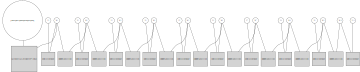

In [6]:
model_generator = hidden_markov_model() | (y = hpmm.Y,)
model_to_plot = RxInfer.getmodel(RxInfer.create_model(model_generator))
GraphViz.load(model_to_plot, strategy = :simple, layout="dot", width=5.,height=5.)

In [7]:
base_time = time()
a = infer(
    model = hidden_markov_model(),
    constraints = hidden_markov_constraints,
    initialization = init,
    data = (y = hpmm.Y[1:T],),
    options = (limit_stack_depth = 500,),
    free_energy = true,
    showprogress=true,
    iterations = 20,    
    warn = false,
    callbacks = (
        on_marginal_update = (model, name, update) -> begin
            open("txts/$(string(time()-base_time)).txt","a") do io
                println(io,"$(update)")
            end
        end,
    )
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Inference results:
  Posteriors       | available for (w)
  Free Energy:     | Real[-46.9501, -46.1856, -45.8682, -45.7966, -45.7724, -45.7645, -45.7618, -45.7608, -45.7604, -45.7602, -45.7601, -45.7601, -45.7601, -45.7601, -45.7601, -45.7601, -45.7601, -45.7601, -45.7601, -45.7601]


In [8]:
function find_viterbi(posteriors_w)
    posteriors_w .|> dist -> (sum(reshape(dist.p, U, X), dims=1) |> Iterators.flatten |> collect |> argmax)
end

find_viterbi (generic function with 1 method)

In [9]:
function find_viterbiu(posteriors_w)
    posteriors_w .|> dist -> (sum(reshape(dist.p, U, X), dims=2) |> Iterators.flatten |> collect |> argmax)
end
vmpus = find_viterbiu(a.posteriors[:w][20]);

In [10]:
# probabilities = zeros(0) .|> ULogFloat64
# maxprob = ULogFloat64(0.)
# for (u,x) in Iterators.product(0:U^T, 0:X^T)
#     us, xs = get_digits(u, U), get_digits(x, X)
#     # println(us)
#     # println(xs)
#     # break
#     total_prob = ULogarithmic(1.)
#     for t in 1:T
#         if t == 1
#             total_prob *= P1[us[1],xs[1]]
#         else
#             total_prob *= Pt[us[t],xs[t],us[t-1],xs[t-1]]
#         end
#         total_prob *= Pe[us[t],xs[t],hpmm.Y[t]]
#     end
#     append!(probabilities, total_prob)
# end

In [11]:
function get_digits(val, base) digits(val, base=base, pad=T) .|> x -> x+1 end

function get_pdf(xs)
    total_prob = ULogarithmic(1.)
    for t in 1:T
        if t == 1
            p1 = 0.
            for u in 1:U
                p1 += P1[u,xs[t]] * Pe[u,xs[t],hpmm.Y[t]]
            end
            total_prob *= p1
        else
            pt = 0.
            for (u, uprev) in Iterators.product(1:U, 1:U)
                pt += Pt[u,xs[t],uprev,xs[t-1]] * Pe[u,xs[t],hpmm.Y[t]]
            end
            total_prob *= pt
        end
    end
    total_prob
end

probabilities = zeros(0) .|> ULogFloat64
maxprob = ULogFloat64(0.)
for x in 0:(X^T-1)
    xs = get_digits(x, X)
    total_prob = get_pdf(xs)
    if maxprob < total_prob
        println(xs, total_prob)
        maxprob = total_prob
    end
    append!(probabilities, total_prob)
end

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]+exp(-19.535596525407534)
[2, 1, 1, 1, 1, 1, 1, 1, 1, 1]+exp(-16.981419336640613)
[2, 1, 2, 1, 1, 1, 1, 1, 1, 1]+exp(-16.412976483344725)
[2, 1, 1, 2, 1, 1, 1, 1, 1, 1]+exp(-16.250863735759676)
[2, 1, 1, 1, 2, 1, 1, 1, 1, 1]+exp(-14.422383891613736)
[2, 1, 2, 1, 2, 1, 1, 1, 1, 1]+exp(-13.853941038317844)
[2, 1, 1, 1, 2, 2, 1, 1, 1, 1]+exp(-13.087233459966848)
[2, 1, 2, 1, 2, 2, 1, 1, 1, 1]+exp(-12.518790606670956)
[2, 1, 1, 1, 2, 1, 2, 1, 1, 1]+exp(-11.13862123366113)
[2, 1, 2, 1, 2, 1, 2, 1, 1, 1]+exp(-10.570178380365238)
[2, 1, 1, 1, 2, 2, 2, 1, 1, 1]+exp(-10.436916129622272)
[2, 1, 2, 1, 2, 2, 2, 1, 1, 1]+exp(-9.86847327632638)
[2, 1, 2, 1, 2, 1, 2, 1, 2, 1]+exp(-9.522100628374583)
[2, 1, 1, 1, 2, 2, 2, 1, 2, 1]+exp(-9.388838377631616)
[2, 1, 2, 1, 2, 2, 2, 1, 2, 1]+exp(-8.820395524335725)


In [12]:
best_path = [2, 1, 2, 1, 2, 2, 2, 1, 2, 1]
analyser = HpmmAnalyser(hpmm, dist) 

pdf(analyser; X = hpmm.X) > pdf(analyser; X = best_path) #usually false

false

In [13]:
len = length(probabilities)
pos = length(probabilities[probabilities .<= get_pdf(hpmm.X)])
pos/len

0.49609375

In [30]:
vmpxs = find_viterbi(a.posteriors[:w][20])
len = length(probabilities)
pos = length(probabilities[probabilities .<= get_pdf(vmpxs)])
pos/len

0.98828125

In [15]:
len = length(probabilities)
pos = length(probabilities[probabilities .<= get_pdf(best_path)])
pos/len

1.0

In [16]:
get_pdf(vmpxs), get_pdf(hpmm.X), get_pdf(best_path)

(+exp(-9.900718588036147), +exp(-14.890027857925046), +exp(-8.820395524335725))

In [17]:
pdf(analyser; X = vmpxs), pdf(analyser; X = hpmm.X), pdf(analyser; X = best_path)

(exp(-5.315727186006743), exp(-8.721437377355702), exp(-6.249992237747996))

# Belief prop

In [18]:
function elbo(mcx, mcu)
    elbo = 0.
    elbo += Iterators.product(1:U, 1:X) .|>
    (
        ((u,x),) -> log(P1[u,x]*Pe[u,x,hpmm.Y[1]]/(mcx.P1[x] * mcu.P1[u])) * mcx.P1[x] * mcu.P1[u]
    ) |> sum
    elbo2 = 0.
    for t in 2:T
        elbo2 += Iterators.product(1:U, 1:X, 1:U, 1:X) .|>
        (
            ((u,x,uprev,xprev),) -> 
            begin
                qtu = VBMC.quuprev(u, uprev, mcx, t, hpmm.Y[t], Pt, Pe)
                qtx = VBMC.qxxprev(x, xprev, mcu, t, hpmm.Y[t], Pt, Pe)
                log(
                    Pt[u,x,uprev,xprev]*Pe[u,x,hpmm.Y[t]]/(qtu * qtx)
                ) * mcx.Pt[x,xprev,t] * mcu.Pt[u,uprev,t]
            end
        ) |> sum
    end
    elbo + elbo2
end

elbo (generic function with 1 method)

In [22]:
mcu = MarkovChain(U, T)
mcx = MarkovChain(X, T)

function norm(A::AbstractArray; p = 2)
    sum(abs.(A) .^ p)^(1 / p)
end

val = 1.0
for _ = 1:200
    tmpP1, tmpPt = mcx.P1 |> deepcopy, mcx.Pt |> deepcopy
    fillalphaX!(mcx, mcu, P1, Pt, Pe, hpmm.Y)
    fillbetaX!(mcx, mcu, Pt, Pe, hpmm.Y)
    VBMC.fillPtx!(mcx, mcu, Pt, Pe, hpmm.Y)

    fillalphaU!(mcu, mcx, P1, Pt, Pe, hpmm.Y)
    fillbetaU!(mcu, mcx, Pt, Pe, hpmm.Y)
    VBMC.fillPtu!(mcu, mcx, Pt, Pe, hpmm.Y)

    signeda = mcx.Pt .|> Logarithmic
    signedb = tmpPt .|> Logarithmic
    val = norm(signeda .- signedb)
    println(elbo(mcx ,mcu) |> Float64)
    if val < 1.0e-14
        break
    end
end

73.58947540004965
3556.6323228712445
97.61051584665572
-0.4400328693226353
-1.0896691766652389
-1.1172932218651839
-1.1041000711572782
-1.1104880544710185
-1.1074484797292108
-1.1089070131031724
-1.108209935461926
-1.1085437307583785
-1.1083840397251374
-1.1084604711196289
-1.108423897184559
-1.1084414002982923
-1.1084330242722553
-1.1084370326693367
-1.108435114448173
-1.1084360324190263
-1.1084355931222336
-1.1084358033489312
-1.1084357027444418
-1.1084357508889076
-1.1084357278491963
-1.1084357388749022
-1.1084357335985522
-1.1084357361236077
-1.108435734915256
-1.1084357354935401
-1.1084357352168115
-1.108435735349152
-1.1084357352858558
-1.1084357353162038
-1.1084357353016576
-1.1084357353085788
-1.1084357353052616


In [25]:
get_pdf(vmpxs), get_pdf(hpmm.X), get_pdf(best_path), get_pdf(VBMC.viterbi(mcx))

(+exp(-9.900718588036147), +exp(-14.890027857925046), +exp(-8.820395524335725), +exp(-8.820395524335725))

In [26]:
vmpxs = VBMC.viterbi(mcx)
len = length(probabilities)
pos = length(probabilities[probabilities .<= get_pdf(vmpxs)])
pos/len

1.0

In [27]:
pos = length(probabilities[probabilities .<= get_pdf(VBMC.viterbi(mcx))])
pos/len

1.0

## ELBOs

In [22]:
function get_digits(val, base) digits(val, base=base, pad=T) .|> x -> x+1 end

function get_pdf(xs, us)
    total_prob = ULogarithmic(1.)
    for t in 1:T
        if t == 1
            total_prob *= P1[us[t],xs[t]] * Pe[us[t],xs[t],hpmm.Y[t]]
        else
            total_prob *= Pt[us[t],xs[t],us[t-1],xs[t-1]] * Pe[us[t],xs[t],hpmm.Y[t]]
        end
    end
    total_prob
end

function get_elbo(mcu, mcx, us, xs)
    total_elbo = ULogarithmic(1.)
    qux = ULogarithmic(1.)
    puxy = get_pdf(xs, us)
    for t in 1:T
        if t == 1
            qux *= mcu.P1[us[t]] * mcx.P1[xs[t]]
        else
            qux *= mcu.Pt[us[t],us[t-1], t] * mcx.Pt[xs[t],xs[t-1], t]
        end
    end
    qux*log(puxy/qux)
end

function total_elbo(mcu, mcx)
    te = ULogarithmic(0.)
    for (x,u) in Iterators.product(0:(X^T-1), 0:(U^T-1))
        xs = get_digits(x, X)
        us = get_digits(u, U)
        e = get_elbo(mcu, mcx, us, xs)
        te += e
    end
    te
end


total_elbo (generic function with 1 method)

In [30]:
get_pdf(vmpxs, vmpus) |> Float64

3.4867207242569914e-16

In [29]:
get_pdf(hpmm.X, hpmm.U) |> Float64

1.5578445538015466e-15

In [32]:
get_pdf(VBMC.viterbi(mcx), VBMC.viterbi(mcu)) |> Float64

8.730009286727867e-16